# Triple-Barrier Labeling: Mathematical Formulation

We consider a univariate price series  

$$
\{ P_t \}_{t=1}^T
$$  

with discrete time steps $t = 1, 2, \dots, T$.  
For each observation, we define a look-ahead horizon $h \in \mathbb{N}$.

---

## 1. Volatility estimation

The local volatility $\sigma_t$ is estimated in one of two ways:

- **Rolling standard deviation (moving window):**

$$
\sigma_t = \sqrt{ \frac{1}{w-1} \sum_{j=0}^{w-1} \big(P_{t-j} - \bar{P}_{t,w}\big)^2 }
\quad\text{with}\quad 
\bar{P}_{t,w} = \frac{1}{w}\sum_{j=0}^{w-1} P_{t-j}
$$

where $w$ is the volatility window length.

- **Exponentially weighted standard deviation:**

$$
\sigma_t = \sqrt{ \frac{ \sum_{j=0}^{\infty} \lambda^j \, (P_{t-j} - \mu_t)^2 }
                         { \sum_{j=0}^{\infty} \lambda^j } }
$$

with decay factor $\lambda \in (0,1)$ and weighted mean $\mu_t$.

In both cases, the volatility series is shifted by one step to ensure that  
$\sigma_t$ uses only information available up to time $t-1$.

---

## 2. Barrier definition

Given multipliers $u > 0$ (upper) and $l > 0$ (lower), the barriers at time $t$ are:

$$
\text{Upper barrier: } U_t = P_t \big(1 + u \cdot \sigma_t \big)
$$

$$
\text{Lower barrier: } L_t = P_t \big(1 - l \cdot \sigma_t \big)
$$

---

## 3. Forward price windows

For each index $t$, define the forward price path over horizon $h$:

$$
W_t = \big( P_{t+1}, P_{t+2}, \dots, P_{t+h} \big)
$$

---

## 4. First barrier hit

We record the first index $\tau_t$ at which $W_t$ crosses either barrier:

$$
\tau_t^{(U)} = \min \{ k \in \{1,\dots,h\} : P_{t+k} \ge U_t \}
$$

$$
\tau_t^{(L)} = \min \{ k \in \{1,\dots,h\} : P_{t+k} \le L_t \}
$$

If the set is empty, the corresponding $\tau$ is undefined.

---

## 5. Label assignment

The label $y_t$ is assigned as:

$$
y_t =
\begin{cases}
+1 & \text{if } \tau_t^{(U)} \text{ exists and } 
                 \big( \tau_t^{(L)} \text{ does not exist } \;\;\text{or}\;\; 
                       \tau_t^{(U)} \le \tau_t^{(L)} \big) \\
-1 & \text{if } \tau_t^{(L)} \text{ exists and } 
                 \big( \tau_t^{(U)} \text{ does not exist } \;\;\text{or}\;\; 
                       \tau_t^{(L)} < \tau_t^{(U)} \big) \\
0  & \text{if neither barrier is hit within horizon $h$}
\end{cases}
$$

The associated **time-to-hit** is:

$$
\theta_t =
\begin{cases}
\tau_t^{(U)} & \text{if label } = +1 \\
\tau_t^{(L)} & \text{if label } = -1 \\
h            & \text{if label } = 0
\end{cases}
$$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
import seaborn as sns
import yfinance as yf

import sys
sys.path.append('../src')
from TripleBarrierLabel import TripleBarrierLabel

# 1. Download Data

In [2]:
prices = yf.download('MSFT', 
                    start='2020-01-01',
                    end='2025-09-01')['Close']

C:\Users\USER\AppData\Local\Temp\ipykernel_32304\2496247924.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download('MSFT',
[*********************100%***********************]  1 of 1 completed


# 2. Initializazion

To create a `TripleBarrierLabel` object, you must provide:

- **`data`** (`pandas.Series` or single-column `pandas.DataFrame`)  
  Price series, typically closing prices.  
  If a DataFrame with one column is given, it will automatically be squeezed into a Series.

- **`horizon`** (`int`)  
  The maximum look-ahead window, i.e. the number of steps forward in which the algorithm will search for barrier hits.  
  Must be a strictly positive integer.

In [3]:
HORIZON = 50
tbl = TripleBarrierLabel(prices, 
                         horizon=HORIZON)

## 2.1. `fit_labels`

After initialization, call `fit_labels(...)` to compute the labels and barriers.  

**Parameters**

- **`up_t`** (`float`)  
  Multiplier for the upper barrier, expressed in units of volatility.  

- **`low_t`** (`float`)  
  Multiplier for the lower barrier, expressed in units of volatility.  

- **`volatility_func`** (`{'moving_std', 'exponential'}`, default=`'moving_std'`)  
  Method for volatility estimation:  
  - `'moving_std'` - rolling standard deviation with user-specified `volatility_window`.  
  - `'exponential'` - exponentially weighted standard deviation with parameters passed via `ewm_params`.  

- **`volatility_window`** (`int`, optional)  
  Size of the rolling window when `volatility_func='moving_std'`.  
  Must be a positive integer.  
  Ignored for `'exponential'`.  

- **`ewm_params`** (`dict`, optional)  
  Keyword arguments passed directly to `pandas.Series.ewm()` when `volatility_func='exponential'`.  
  Must be a dictionary.  
  Ignored for `'moving_std'`.  

---

**Input validation performed**

- Ensures that `volatility_func` is one of the allowed values.  
- If `volatility_func='moving_std'`:  
  - Requires `volatility_window` to be provided and to be an integer.  
- If `volatility_func='exponential'`:  
  - Requires `ewm_params` to be provided and to be a dictionary.  
- Issues warnings if irrelevant parameters are passed (e.g. `ewm_params` with `'moving_std'` or `volatility_window` with `'exponential'`).  

---

**Behavior on call**

- Computes a local volatility series using the chosen method, shifted by one step to avoid look-ahead bias.  
- Constructs forward price windows of length = `horizon`.  
- Builds dynamic upper and lower barriers for each observation using the local volatility.  
- Determines the first barrier hit (if any) within the horizon and assigns the corresponding label.  
- Stores the computed results internally for later access via properties.


In [4]:
ewm_params = {'alpha':0.9}

tbl.fit_labels(up_t=0.03,
              low_t=0.02,
              volatility_func='exponential',
              ewm_params=ewm_params)

# 3. Attributes

## 3.1. `Labels`

The property `labels` stores the class assignments from the triple-barrier method.

- **Values**:  
  - `+1` → the upper barrier was hit first.  
  - `-1` → the lower barrier was hit first.  
  - `0` → no barrier was hit within the specified horizon.  

- **Shape**:  
  A NumPy array of length equal to the number of valid observations.  

- **Usage**:  
  Use `labels = tbl.labels` to access the computed labels after running `fit_labels(...)`.  
  They can be analyzed directly or used as target variables in supervised machine learning tasks.

In [5]:
labels = tbl.labels

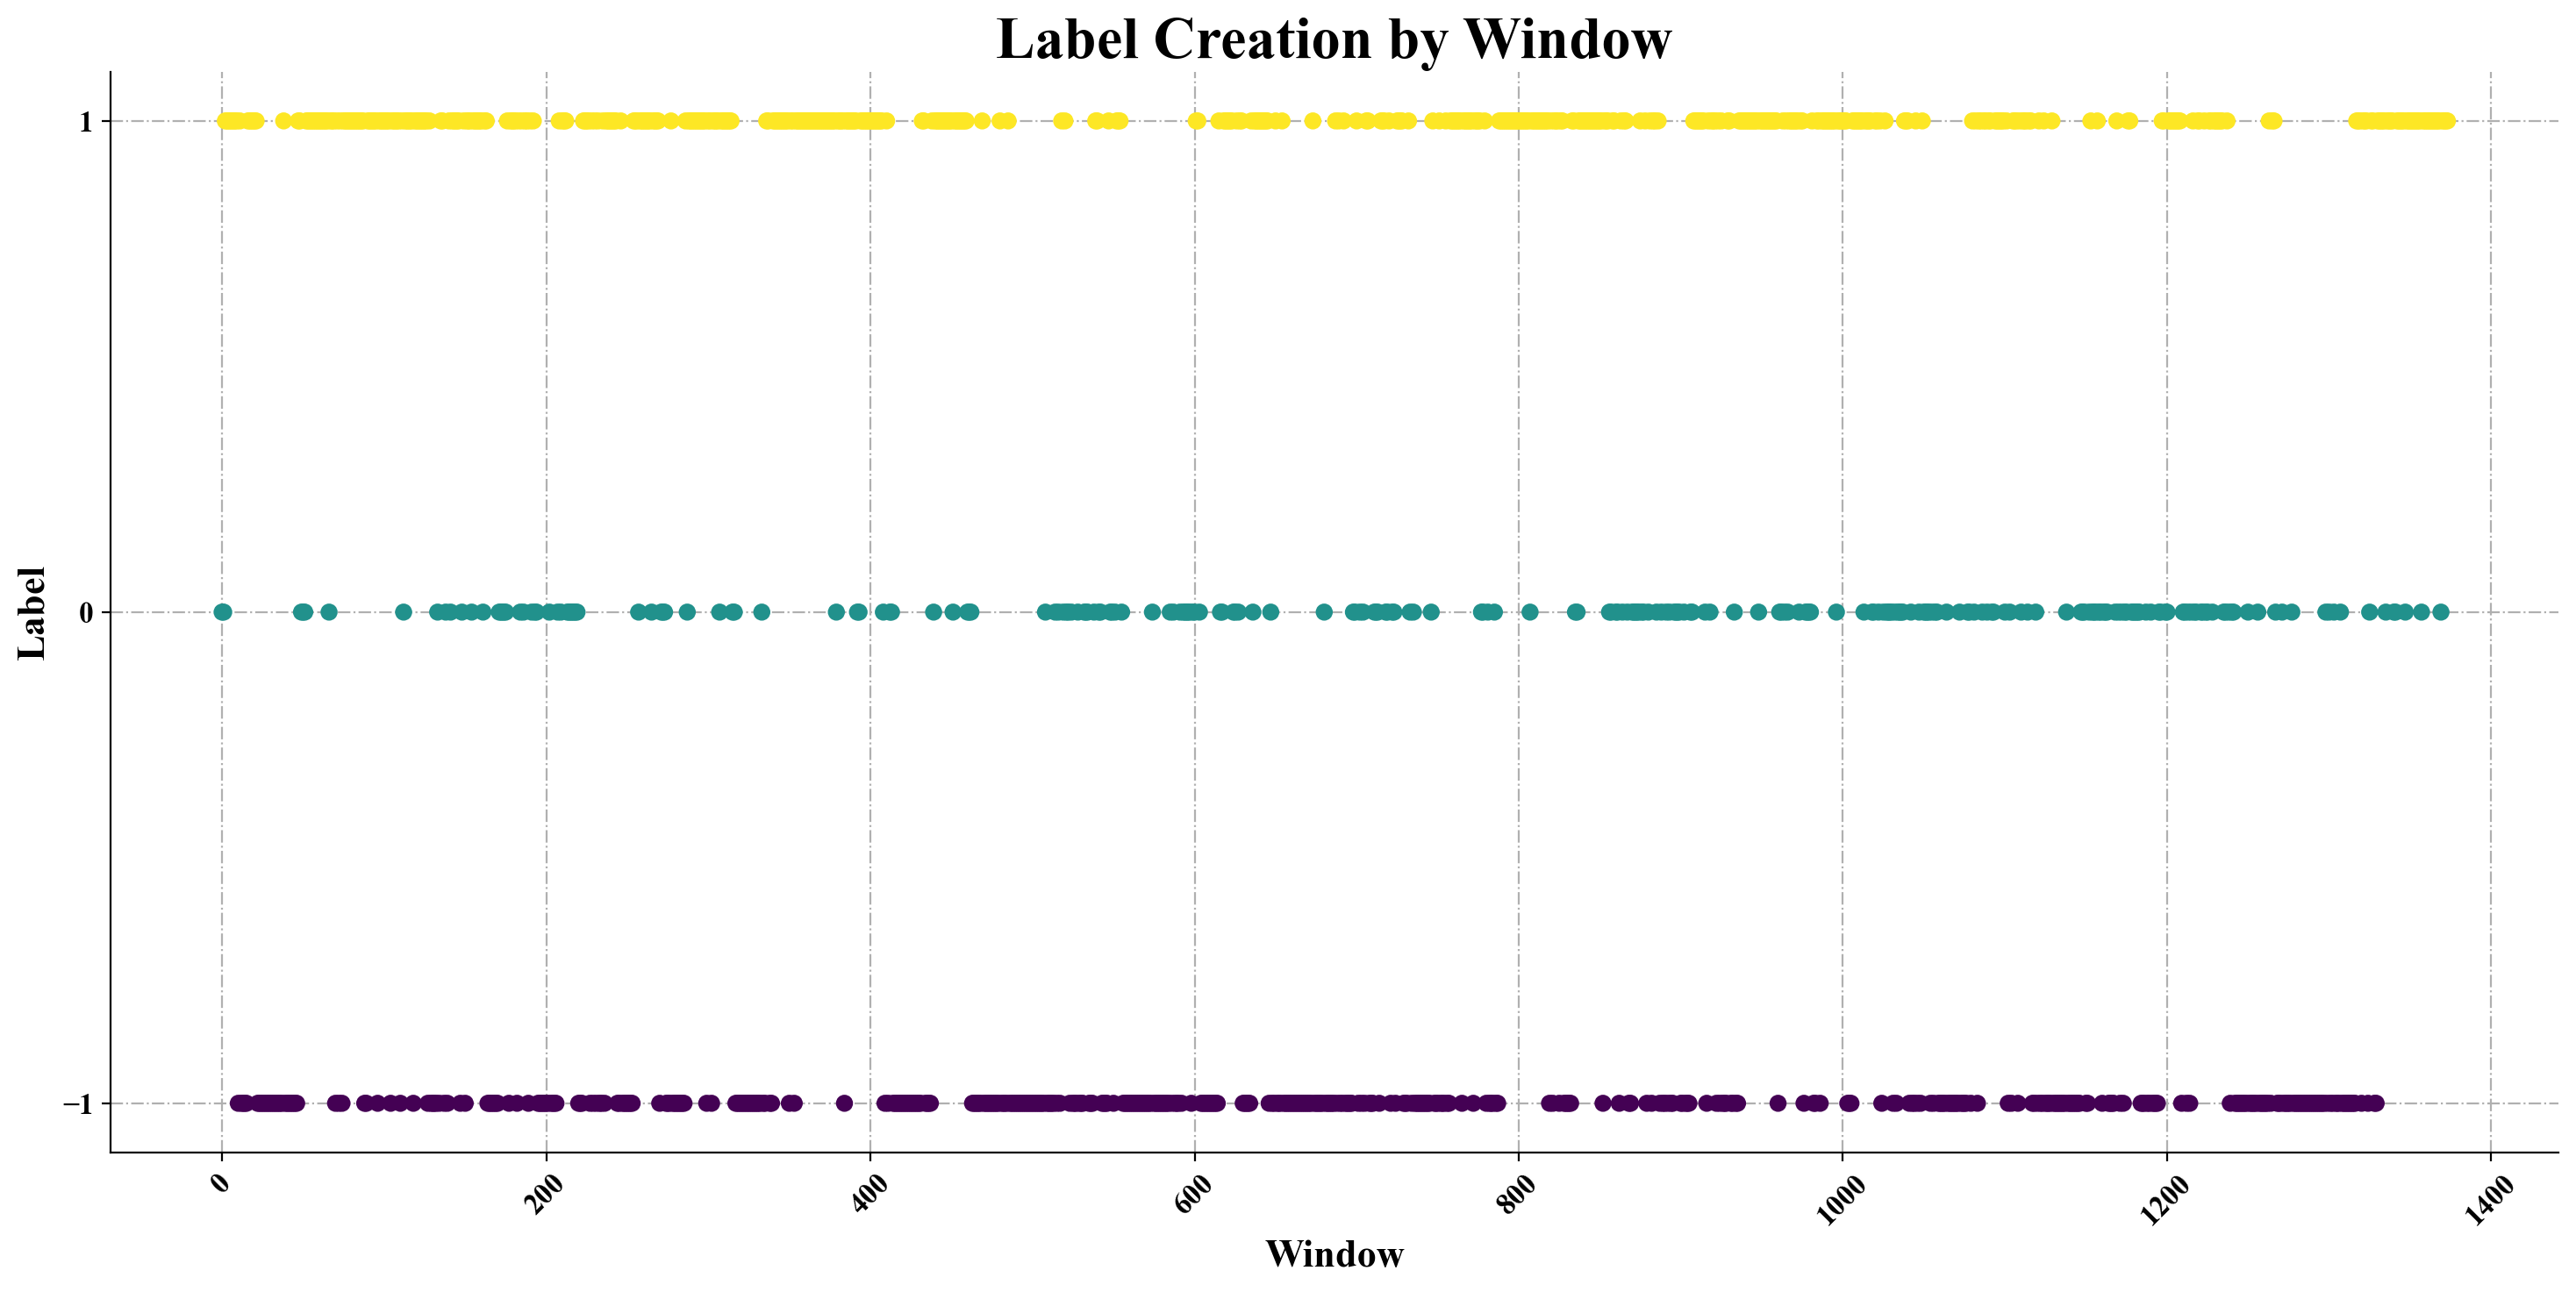

In [6]:
plt.figure(figsize=(18,8), dpi=200)

plt.scatter(range(len(labels)), labels,
            c=labels,
            zorder=2)

plt.xticks(size=12, weight='bold', rotation=45)
plt.yticks(np.arange(-1, 1.1, 1),
           size=12, weight='bold')

plt.xlabel('Window', size=16, weight='bold')
plt.ylabel('Label', size=16, weight='bold')

plt.title('Label Creation by Window', size=24, weight='bold')


plt.grid(ls='-.')
sns.despine()
plt.show()

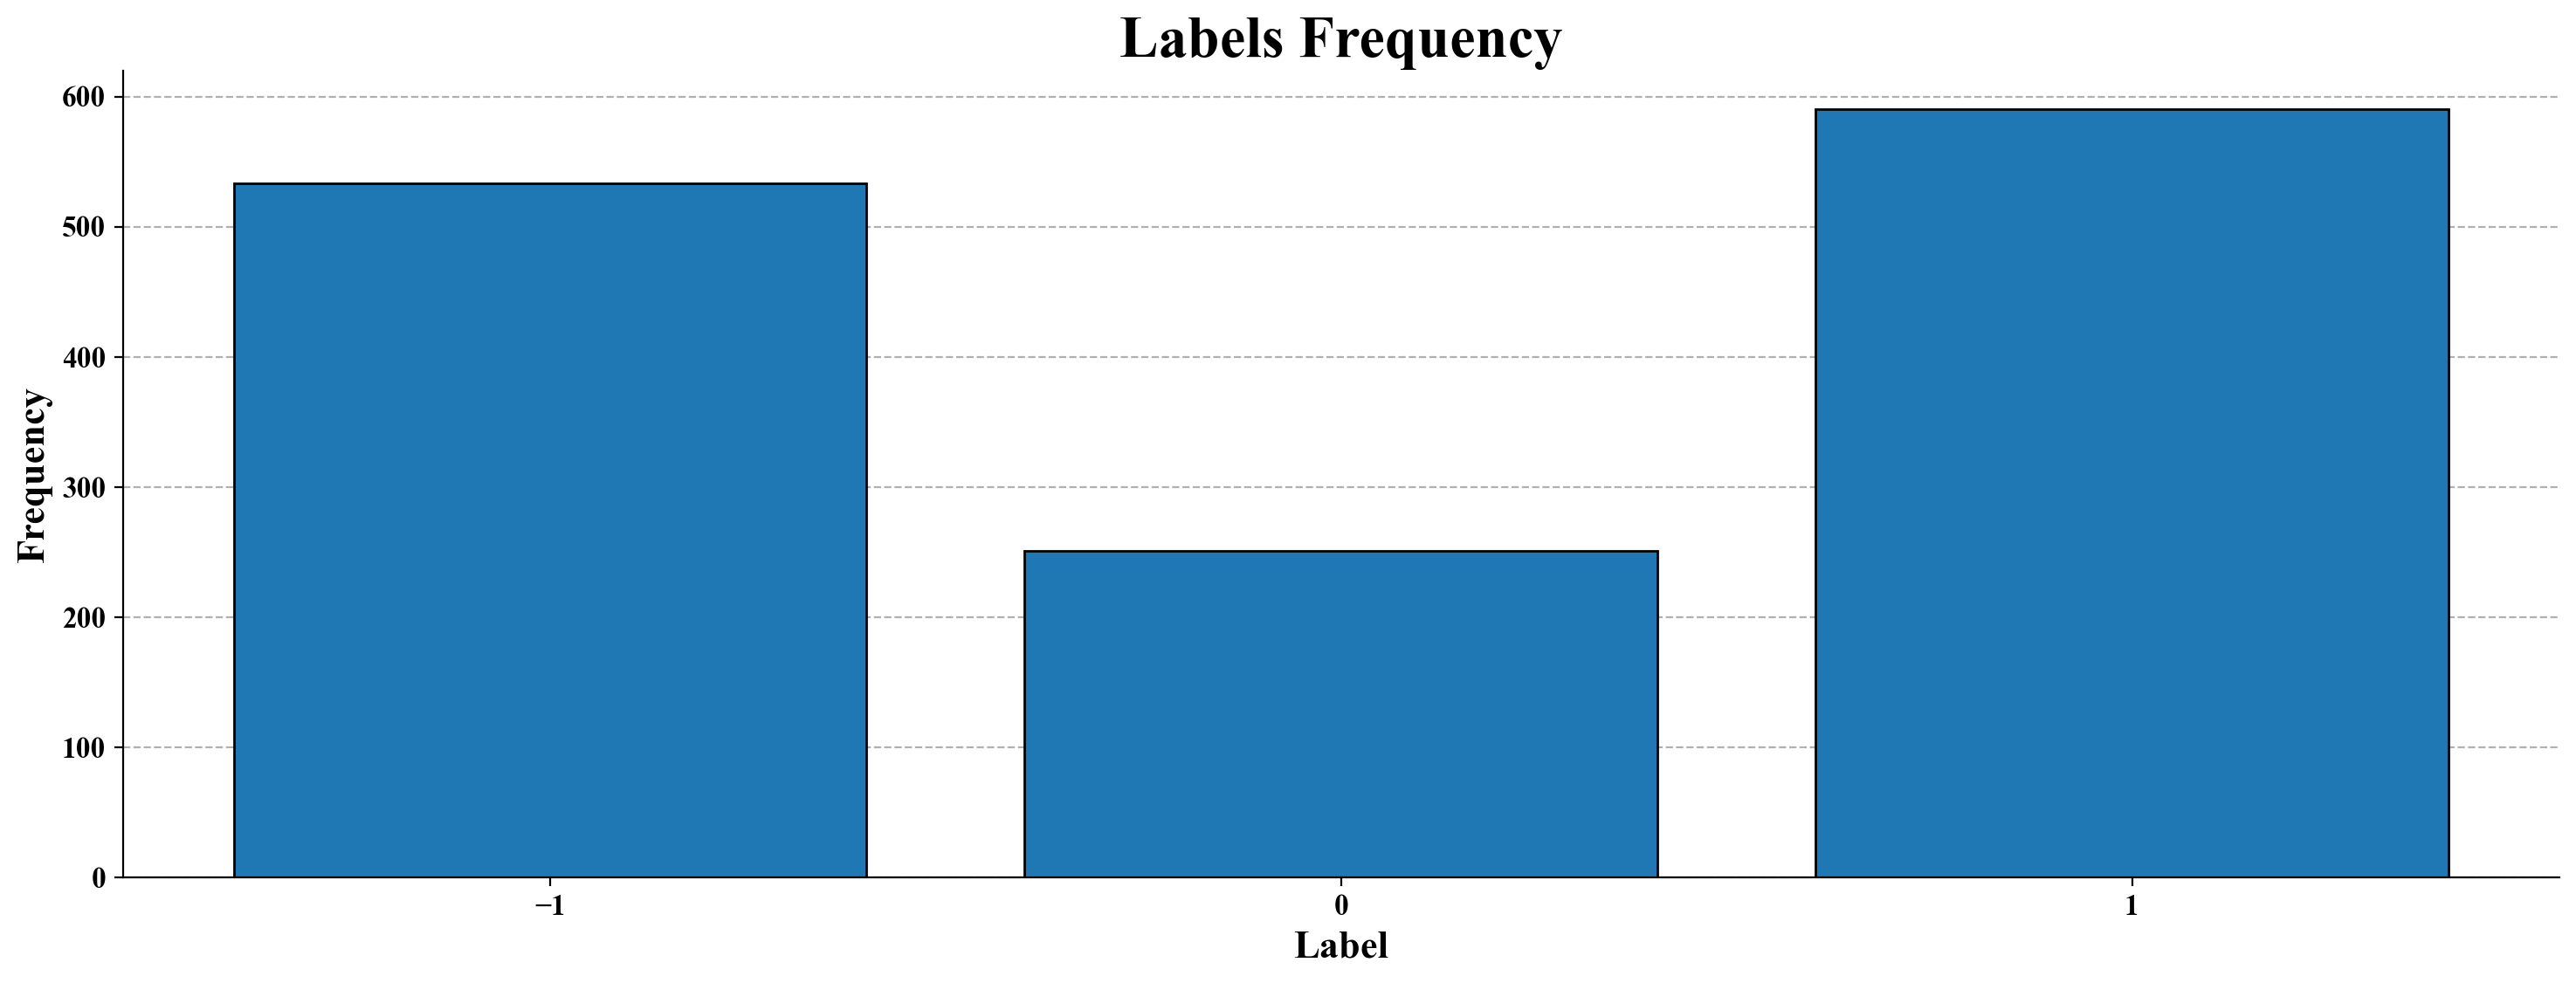

In [7]:
plt.figure(figsize=(18,6), dpi=200)
plt.bar(x = pd.Series(labels).value_counts().index,
       height=pd.Series(labels).value_counts().values,
       edgecolor='k',
       zorder=2)

plt.xticks(np.arange(-1, 1.1, 1),
          size=12, weight='bold')
plt.yticks(size=12, weight='bold')

plt.xlabel('Label', size=16, weight='bold')
plt.ylabel('Frequency', size=16, weight='bold')

plt.title('Labels Frequency', size=24, weight='bold')

plt.grid(ls='--', axis='y', zorder=0)
sns.despine()
plt.show()

## 3.2. `time_to_hit`

The property `time_to_hit` provides, for each observation, the number of steps forward (within the defined horizon) until a barrier was hit.  

- **Values**:  
  - A non-negative integer = number of steps until the first hit (upper or lower).  
  - Equal to the horizon if no barrier was hit within the look-ahead window.  

- **Shape**:  
  NumPy array of length equal to the number of valid observations.  

---

⚠️ **Note**:  
This attribute is **not part of the original implementation by López de Prado**.  
It is an additional feature introduced here to provide more granular information about the dynamics of barrier hits, beyond the class label itself.


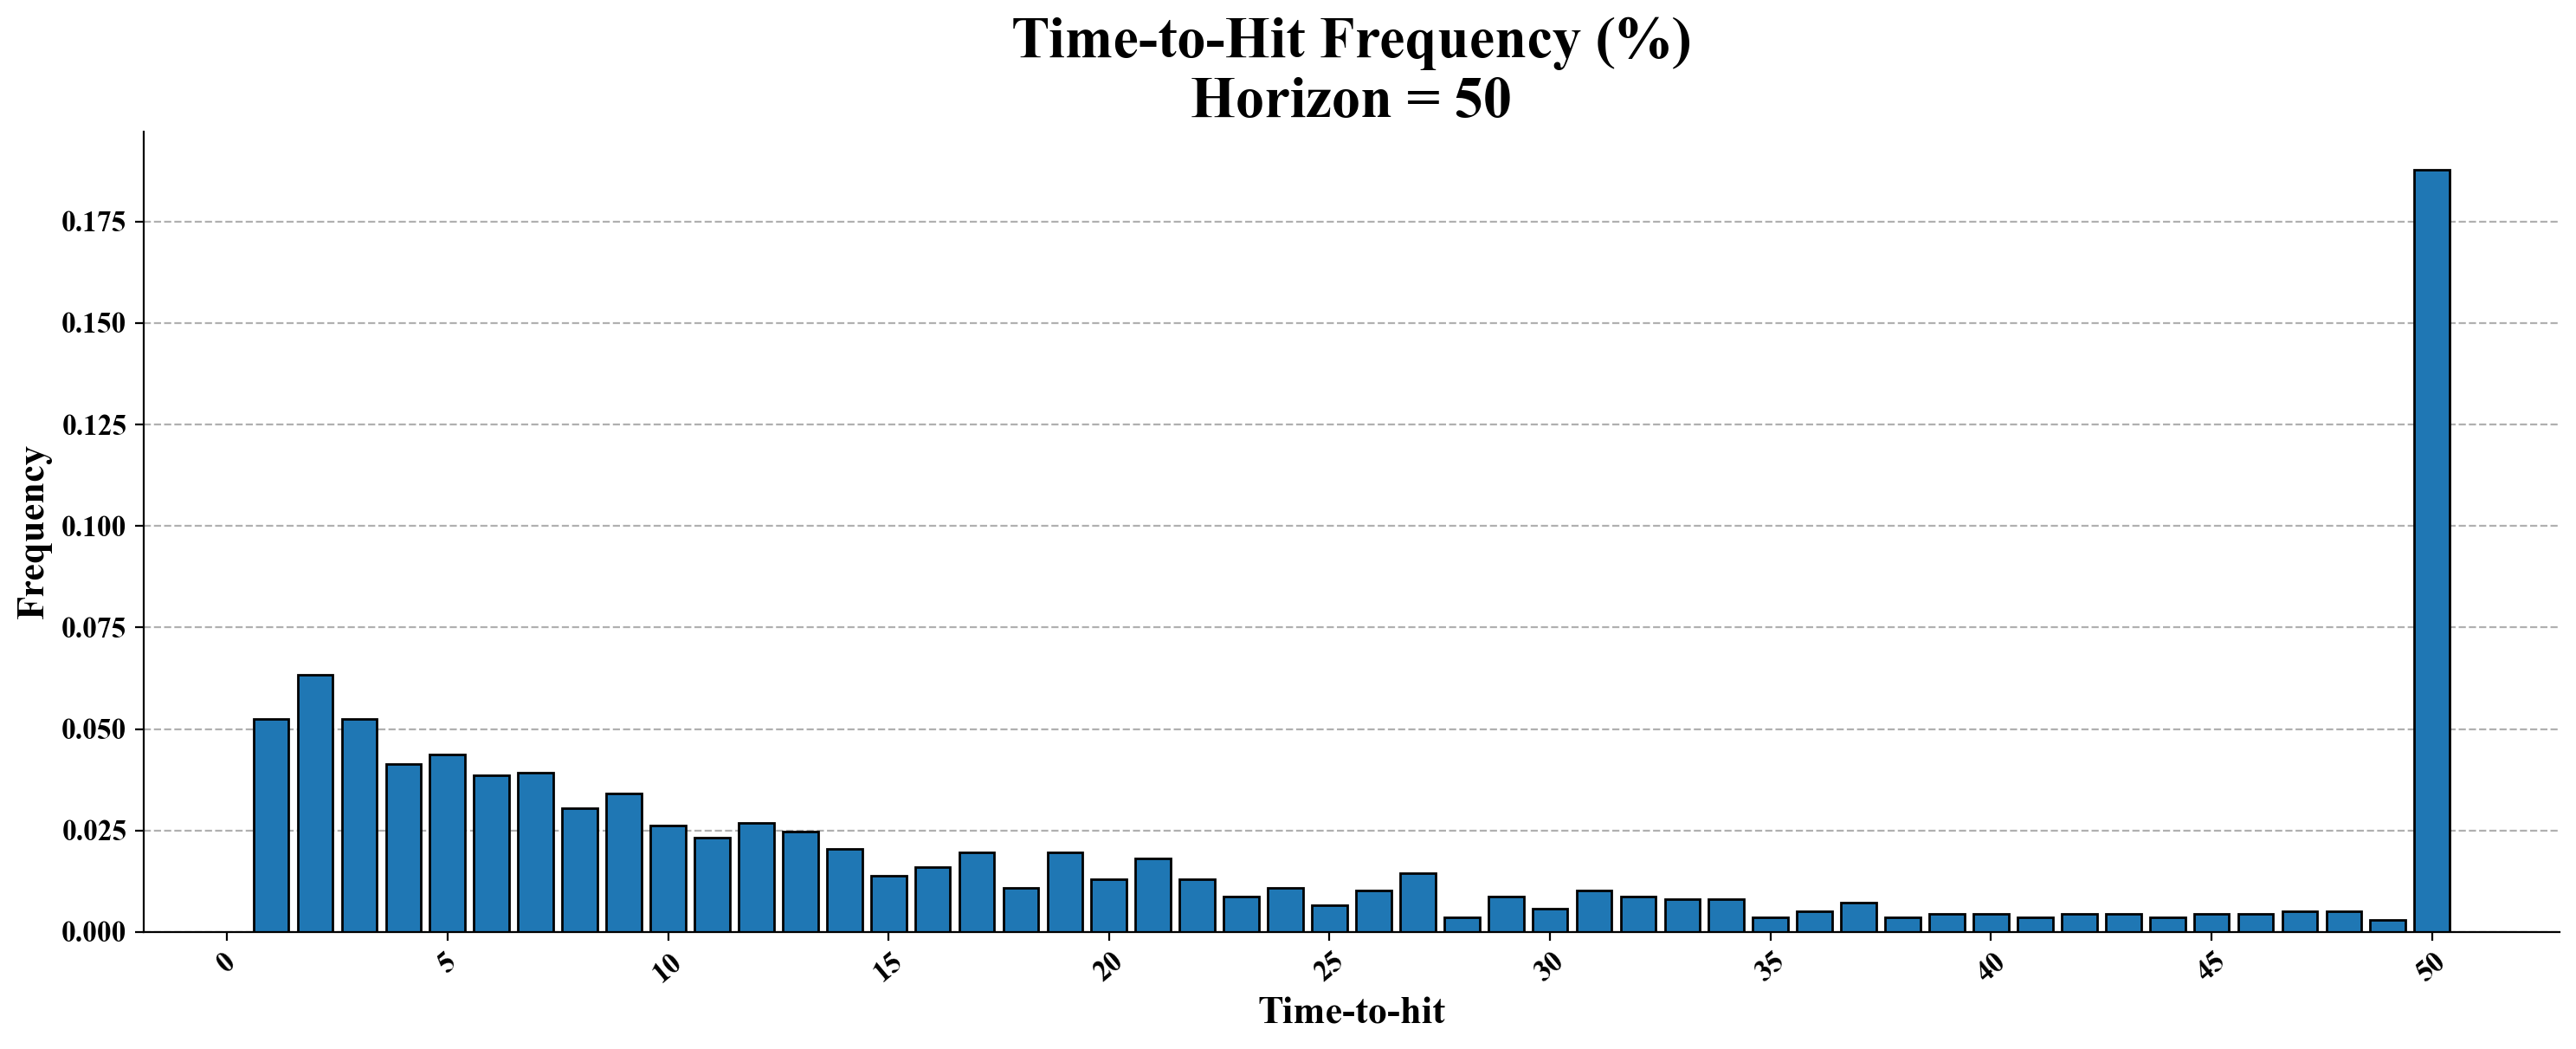

In [8]:
tth = tbl.time_to_hit
plt.figure(figsize=(18,6), dpi=200)
plt.bar(pd.Series(tth).value_counts().index,
        pd.Series(tth).value_counts(normalize=True).values,
       edgecolor='k',
       zorder=2)

plt.xticks(range(0, 51, 5), size=12, weight='bold', rotation=40)
plt.yticks(size=12, weight='bold')

plt.xlabel('Time-to-hit', size=16, weight='bold')
plt.ylabel('Frequency', size=16, weight='bold')
plt.title(f'Time-to-Hit Frequency (%)\nHorizon = {HORIZON}', size=24, weight='bold')

plt.grid(ls='--', axis='y', zorder=0)

sns.despine()
plt.show()

## 3.3. `volatility_funtion`

The property `volatility_function` stores the estimated volatility series used for barrier construction.  

- **Computation**:  
  Calculated either as a rolling standard deviation or as an exponentially weighted standard deviation (depending on the chosen method in `fit_labels`).  
  A one-step backward shift is applied to avoid look-ahead bias.  

- **Values**:  
  NumPy array with length equal to the number of observations.  
  The first entries may be `NaN` due to the rolling window or exponential warm-up.  


In [9]:
tbl.volatility_function

array([       nan,        nan, 1.34528964, ..., 1.86114917, 3.18649173,
       2.56015719])

## 3.4. `windows`

## 3.4 Barriers

The property `barriers` stores the dynamic upper and lower price thresholds used in the triple-barrier method.  

- **Values**:  
  A tuple of two NumPy arrays `(lower, upper)`.  
  Each array has the same length as the number of valid observations.  
- **Interpretation**:  
  At each time step `t`, barriers are defined relative to the estimated volatility, scaled by the input multipliers.  


In [10]:
low_b, up_b = tbl.barriers

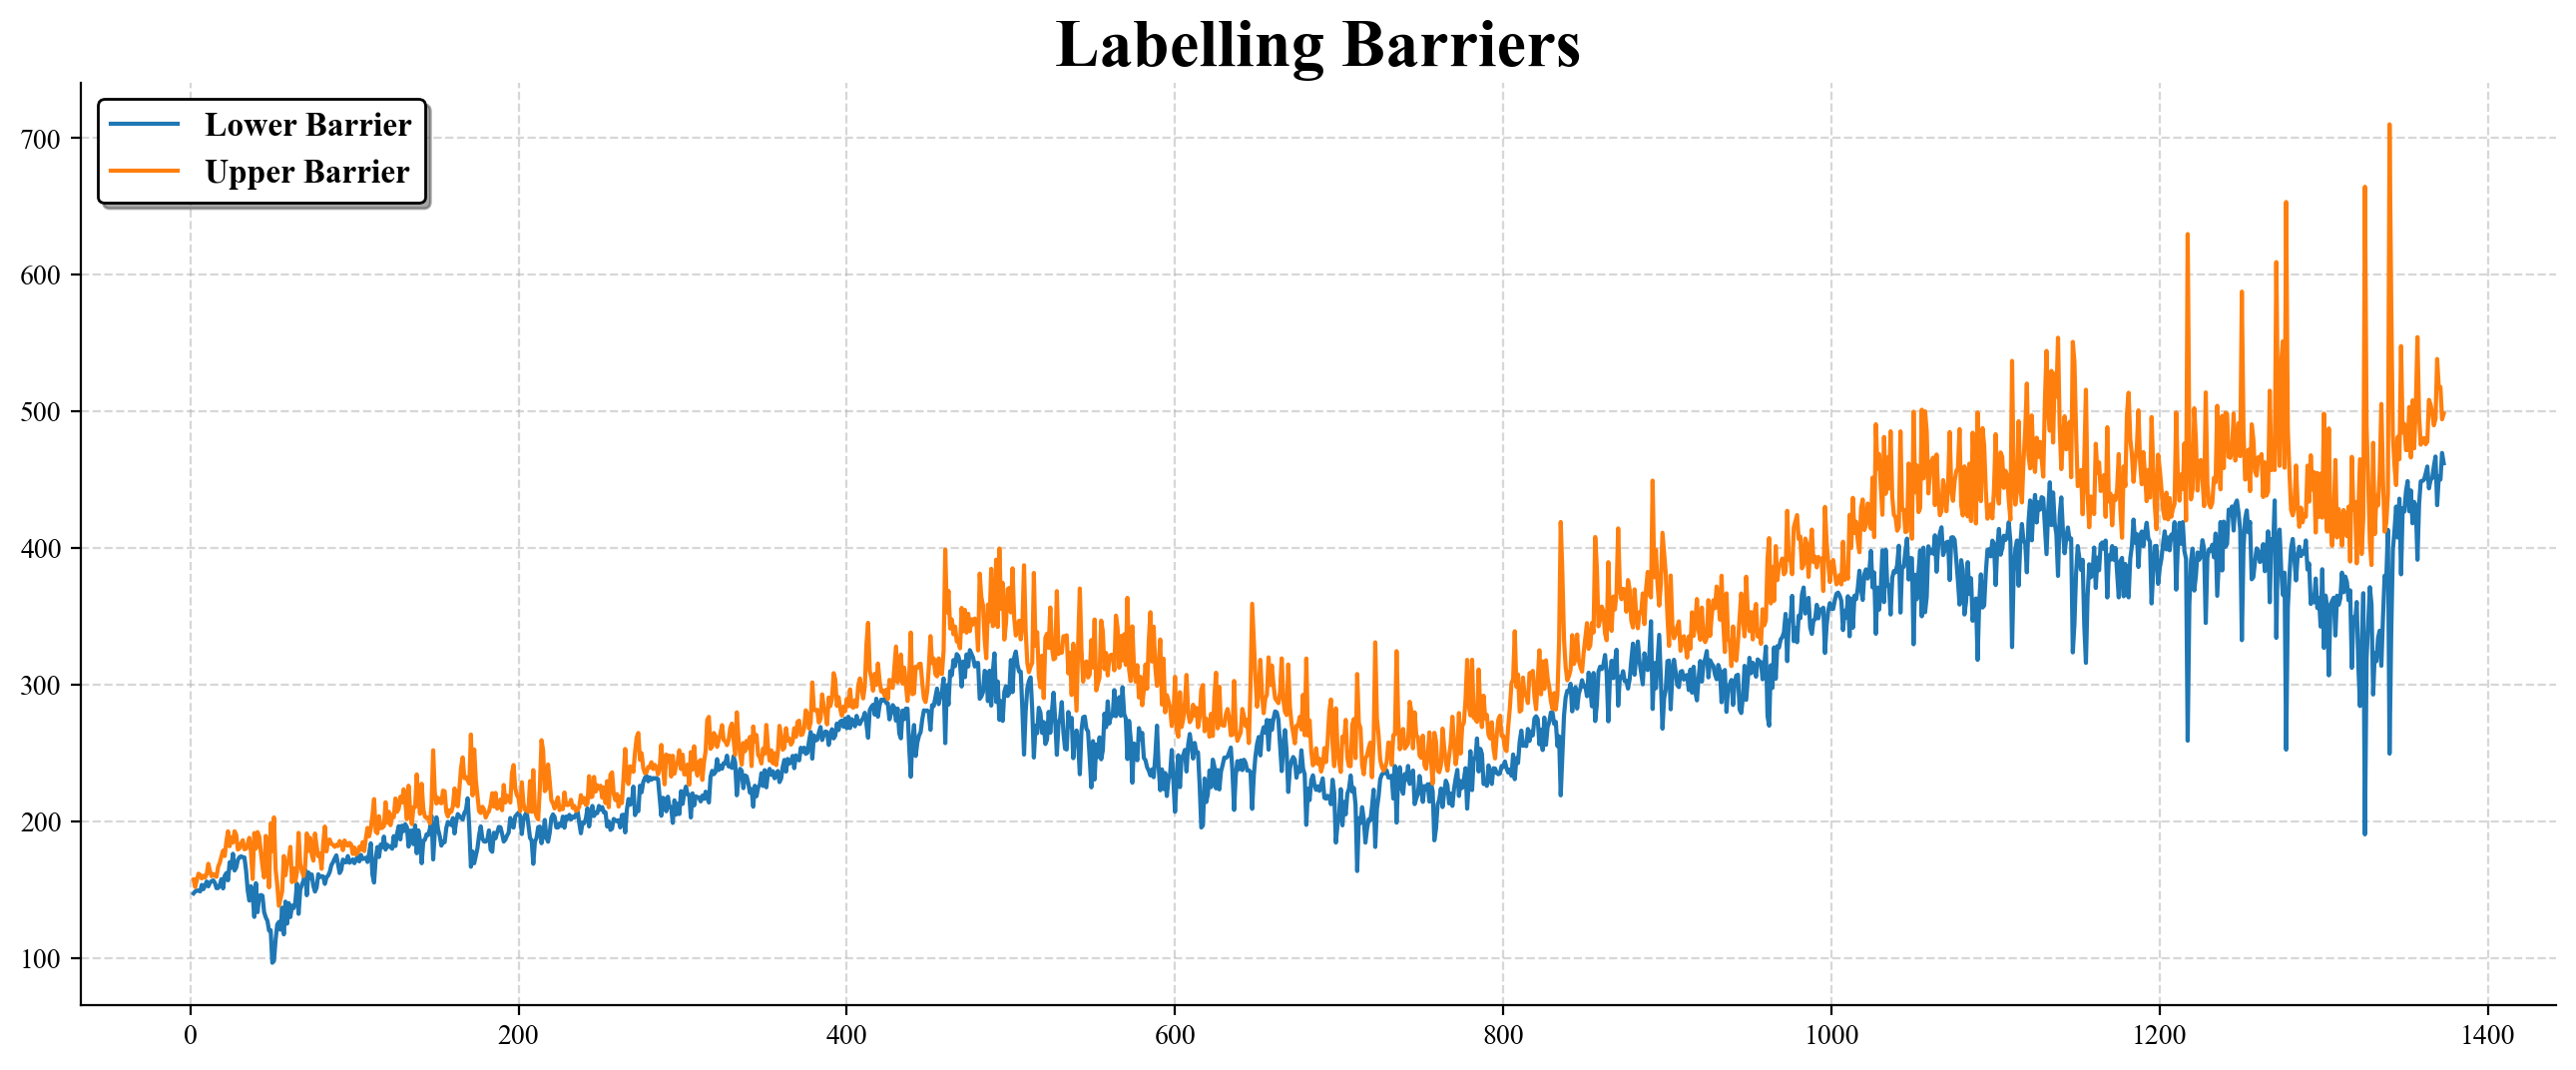

In [11]:
plt.figure(figsize=(16,6), dpi=200)

plt.plot(low_b, label='Lower Barrier')
plt.plot(up_b, label='Upper Barrier')

plt.title('Labelling Barriers', size=24, weight='bold')

plt.grid(ls='--', alpha=.5)
plt.legend(edgecolor='k',
           shadow=True,
           prop={'size': 12, 'weight': 'bold'}
          )
sns.despine()
plt.show()

## 3.5 Windows

The property `windows` contains the forward-looking price paths used for label determination.  

- **Values**:  
  A list (or array) of NumPy arrays, each of length equal to the horizon.  
- **Interpretation**:  
  For each observation at time `t`, the window covers prices from `t+1` up to `t+horizon`.  
  These sequences are checked against the barriers to determine the first hit.

In [12]:
windows = tbl.windows

In [13]:
windows[0][:10]

array([[150.88861084],
       [151.27865601],
       [149.89930725],
       [152.28692627],
       [154.18948364],
       [153.47602844],
       [155.32150269],
       [154.22750854],
       [155.22636414],
       [158.07061768]])